In [ ]:
path = '/content/drive/MyDrive/MineriaTextos/proyecto_mineria_textos_turismo/'
#path="/content/drive/MyDrive/proyecto_mineria_textos_turismo/"
sent_path_train = 'rest-mex_2021_Sentiment_data_train/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [ ]:
!pip install -U deep_translator
!pip install transformers
!pip install scikit-multilearn

     |████████████████████████████████| 2.3MB 8.4MB/s 
     |████████████████████████████████| 3.3MB 45.6MB/s 
     |████████████████████████████████| 901kB 40.8MB/s 
     |████████████████████████████████| 92kB 3.9MB/s 


In [ ]:
from deep_translator import GoogleTranslator

from skmultilearn.model_selection import iterative_train_test_split

import pandas as pd
pd.set_option('max_colwidth', 400)
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import os
import random
import numpy as np

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load data and augmentation

In [ ]:
df = pd.read_csv(path + sent_path_train + 'rest-mex_2021_Sentiment_data_train.csv')
#df = pd.read_csv(path + 'sentiment_augmentation.csv')
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
#df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('level_0', axis=1, inplace=True)
df.fillna('', inplace=True)
print(df.shape)
df.head()

(5197, 8)


,Title,Opinion,Place,Gender,Age,Country,Date,Label
0,"""¡Momias, demasiado impresionante!""","""Las momias están en muy buen estado de conservación, más de 30 para ver. La energía del lugar es pesada, de baja vibración. Todo mi grupo quedó negativamente impresionado. Algunas expresiones de las caras son horribles. Esas imágenes como de ZOMBIES quedaron grabadas en lo profundo de las mentes de quienes las vimos, otros de mis acompañantes se tuvieron que salir del museo. Salimos con ganas...",Museo de las Momias,Male,53,México,22/10/2016,1
1,Comida cara,Tienen carteles con comida cortida de 40 y no te vendían nada el mínimo era 90 y debías pagar agua y sin buen sabor,Mercado Hidalgo,N/I,-1,México,2018,1
2,"""No coman ahí""","""Creo que es muy insalubre, hay basura por todos lados y aunque la comida es rica y barata, creo que se pueden visitar otros restaurantes.""",Mercado Hidalgo,Female,61,México,15/01/2013,1
3,"""Momificado""","""Para mí gusto no vale la pena... tristemente es un gran atractivo pero descuidado, complicado para llegar y caótico... las momias empolvadas y mal tenidas según mi impresión. No recomiendo gastar el tiempo allí habiendo cosas más llamativas. A menos que la administración del lugar mejoren las condiciones.""",Museo de las Momias,Male,38,Colombia,11/05/2017,1
4,"""Incómodo y cero romántico""","""Es un lugar poco interesante y que se conoce en menos de un minuto. La cantidad de gente que lo visita es tanta que lo hacen poco agradable. Lo peor son los vendedores locales que incomodan aconsando a los turistas para contarles la leyenda y sacarles la foto. En resumen, el lugar menos romántico que he visto ¿quién va a querer romancear con una bola de mirones y que te quieran presionar para...",Callejón del Beso,Female,38,Francia,28/11/2017,1


In [ ]:
df.columns

Index(['Title', 'Opinion', 'Place', 'Gender', 'Age', 'Country', 'Date',
       'Label'],
      dtype='object')

In [ ]:
def augmentation(data, label, idioma):
  #data: data frame 
  #idioma: lista de idiomas a traducir
  data = data[data.Label == label]
  aumento = []
  for i in idioma:
    aux = pd.DataFrame({c:[] for c in data.columns})
    opinion_en = data['Opinion'].apply(lambda x: GoogleTranslator(source='es', target = i).translate(x))
    opinion_es = opinion_en.apply(lambda x: GoogleTranslator(source = i, target = 'es').translate(x))
    
    title_en = data['Title'].apply(lambda x: GoogleTranslator(source = 'es', target = i).translate(x))
    title_es = title_en.apply(lambda x: GoogleTranslator(source = i, target = 'es').translate(x))
    aux['Title'] = title_es
    aux['Opinion'] = opinion_es
    aux['Place'] = data['Place']
    aux['Gender'] = data['Gender']
    aux['Age'] = data['Age']
    aux['Country'] = data['Country']
    aux['Date'] = data['Date']
    aux['Label'] = label 

    aumento.append(aux)
  return pd.concat(aumento, axis = 0)

In [ ]:
%%time
aux_label_1 = augmentation(df, 1, ['en','fr','de','zh'])
aux_label_2 = augmentation(df, 2, ['en','fr','de'])

In [ ]:
df_aug = pd.concat([df, aux_label_1, aux_label_2], axis = 0)
#df_aug.reset_index(inplace = True)
print(df.shape)
print(df_aug.shape)

(5197, 8)
(5952, 8)


In [ ]:
df_aug.head()

,Title,Opinion,Place,Gender,Age,Country,Date,Label
0,"""¡Momias, demasiado impresionante!""","""Las momias están en muy buen estado de conservación, más de 30 para ver. La energía del lugar es pesada, de baja vibración. Todo mi grupo quedó negativamente impresionado. Algunas expresiones de las caras son horribles. Esas imágenes como de ZOMBIES quedaron grabadas en lo profundo de las mentes de quienes las vimos, otros de mis acompañantes se tuvieron que salir del museo. Salimos con ganas...",Museo de las Momias,Male,53,México,22/10/2016,1
1,Comida cara,Tienen carteles con comida cortida de 40 y no te vendían nada el mínimo era 90 y debías pagar agua y sin buen sabor,Mercado Hidalgo,N/I,-1,México,2018,1
2,"""No coman ahí""","""Creo que es muy insalubre, hay basura por todos lados y aunque la comida es rica y barata, creo que se pueden visitar otros restaurantes.""",Mercado Hidalgo,Female,61,México,15/01/2013,1
3,"""Momificado""","""Para mí gusto no vale la pena... tristemente es un gran atractivo pero descuidado, complicado para llegar y caótico... las momias empolvadas y mal tenidas según mi impresión. No recomiendo gastar el tiempo allí habiendo cosas más llamativas. A menos que la administración del lugar mejoren las condiciones.""",Museo de las Momias,Male,38,Colombia,11/05/2017,1
4,"""Incómodo y cero romántico""","""Es un lugar poco interesante y que se conoce en menos de un minuto. La cantidad de gente que lo visita es tanta que lo hacen poco agradable. Lo peor son los vendedores locales que incomodan aconsando a los turistas para contarles la leyenda y sacarles la foto. En resumen, el lugar menos romántico que he visto ¿quién va a querer romancear con una bola de mirones y que te quieran presionar para...",Callejón del Beso,Female,38,Francia,28/11/2017,1


In [ ]:
aux_label_1[aux_label_1.index == 1]

,Title,Opinion,Place,Gender,Age,Country,Date,Label
1,Comida cara,"Tienen carteles con comida cortada de 40 y no te vendieron nada, el mínimo era 90 y tenías que pagar por agua y sin buen gusto",Mercado Hidalgo,N/I,-1,México,2018,1
1,Comida cara,"Tienen carteles con comida cortada de 40 y no te vendieron nada, el mínimo era 90 y tenías que pagar por agua y sin sabor.",Mercado Hidalgo,N/I,-1,México,2018,1
1,Comida cara,"Cortaban carteles con comida de más de 40 y no te vendían nada, el mínimo era de 90 y tenías que pagar por agua y sin sabor?",Mercado Hidalgo,N/I,-1,México,2018,1
1,Comida cara,"Hay 40 yuanes de comida en su cartel, no te vendieron nada, el mínimo es de 90 yuanes, tienes que pagar por el agua y sabe mal.",Mercado Hidalgo,N/I,-1,México,2018,1


In [ ]:
#df_aug.to_csv(path + 'sentiment_augmentation.csv')

In [ ]:
df_aug=pd.read_csv(path + 'sentiment_augmentation.csv')

df_aug.drop(['Unnamed: 0', 'index'],inplace=True, axis=1)
df_aug.head()

,Title,Opinion,Place,Gender,Age,Country,Date,Label
0,"""¡Momias, demasiado impresionante!""","""Las momias están en muy buen estado de conservación, más de 30 para ver. La energía del lugar es pesada, de baja vibración. Todo mi grupo quedó negativamente impresionado. Algunas expresiones de las caras son horribles. Esas imágenes como de ZOMBIES quedaron grabadas en lo profundo de las mentes de quienes las vimos, otros de mis acompañantes se tuvieron que salir del museo. Salimos con ganas...",Museo de las Momias,Male,53,México,22/10/2016,1
1,Comida cara,Tienen carteles con comida cortida de 40 y no te vendían nada el mínimo era 90 y debías pagar agua y sin buen sabor,Mercado Hidalgo,N/I,-1,México,2018,1
2,"""No coman ahí""","""Creo que es muy insalubre, hay basura por todos lados y aunque la comida es rica y barata, creo que se pueden visitar otros restaurantes.""",Mercado Hidalgo,Female,61,México,15/01/2013,1
3,"""Momificado""","""Para mí gusto no vale la pena... tristemente es un gran atractivo pero descuidado, complicado para llegar y caótico... las momias empolvadas y mal tenidas según mi impresión. No recomiendo gastar el tiempo allí habiendo cosas más llamativas. A menos que la administración del lugar mejoren las condiciones.""",Museo de las Momias,Male,38,Colombia,11/05/2017,1
4,"""Incómodo y cero romántico""","""Es un lugar poco interesante y que se conoce en menos de un minuto. La cantidad de gente que lo visita es tanta que lo hacen poco agradable. Lo peor son los vendedores locales que incomodan aconsando a los turistas para contarles la leyenda y sacarles la foto. En resumen, el lugar menos romántico que he visto ¿quién va a querer romancear con una bola de mirones y que te quieran presionar para...",Callejón del Beso,Female,38,Francia,28/11/2017,1
...,...,...,...,...,...,...,...,...
5947,"""Ansiedad""","""No me gustó ver las momias, me asustó, no es para gente sensible, incluso hay bebés :(. El sitio está en perfecto estado. Te das la explicación en el museo, está muy bien establecido. Haz algo así, entonces sí es recomendable "".",Museo de las Momias,Female,30,Paraguay,03/07/2016,2
5948,"""Tema interesante / museo incompleto""","“Fue muy decepcionante. El tema es súper interesante y es una lástima que no se invierta la estructura del lugar. También necesitamos más información sobre las momias, cómo fueron descubiertas, las condiciones del lugar donde estaban originalmente, los naturales Proceso de momificación, etc. Se debe invertir en la mejora e información de este museo para que se pueda aprender sobre la descompos...",Museo de las Momias,Female,34,Alemania,07/07/2015,2
5949,"""Esperaba más""","""La verdad no vale mucho porque dejaron muy pocas momias. 50 pesos aproximadamente y parece muy caro"".",Museo de las Momias,Male,-1,México,19/12/2016,2
5950,"""Algo grotesco, pero algo interesante""","""No es mi tipo de museo. Es grotesco, pero podría haber sido peor. La visita solo toma 20 minutos. Es uno de los lugares imperdibles de Guanajuato. Pero no necesariamente"".",Museo de las Momias,Male,57,Colombia,03/11/2017,2


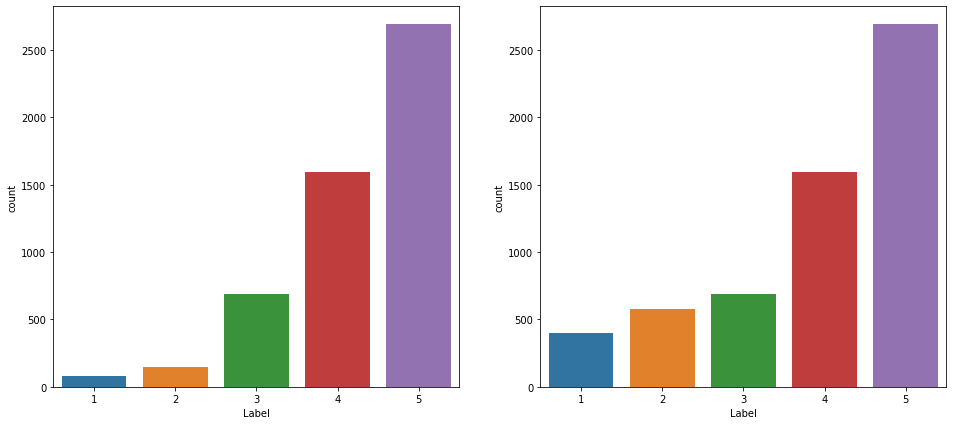

In [ ]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.countplot(data = df, x = 'Label')
plt.subplot(122)
sns.countplot(data = df_aug, x = 'Label')